Lets train on our new model and see how it goes

In [27]:
import torch
import torch.nn as nn
import copy
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import ConfusionMatrixDisplay, classification_report


from combined_data_script import get_data
from medication_data_script import LeakageOption
from RegNet import RegNet


In [28]:
data_dic = get_data(flatten=False,leakage_option=LeakageOption.FULL_LEAKAGE, stride=50, filter_static=False)

In [29]:
train, dev, test = data_dic['train'], data_dic['dev'], data_dic['test'] 

In [30]:
len(train), len(dev), len(test) #note it is NOT shuffled we will nedd to do this 

(10426, 1302, 1306)

In [31]:
X0, y0 = train[0]
X0.shape

torch.Size([6, 400])

In [41]:
#important that we shuffle THEY ARE NOT IF WE DONT
torch.manual_seed(69)
train_loader = DataLoader(train, batch_size=64, shuffle=True)
dev_loader = DataLoader(dev, batch_size=2048, shuffle=True)

In [42]:
dropout = 0.85
model = RegNet(dropout=dropout)

device = "cuda:0"
model = model.to(device)
pos_weight_tensor = torch.tensor([0.87]).to(device)
criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)
optimizer =  torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.01)

In [43]:
lossi = []
devlossi = []

best_dev_loss = float('inf')
best_model = None

In [44]:
for epoch in tqdm(range(100)):
    model.train()
    loss_total = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) 

        logits = model(X_batch)
        loss = criterion(logits, y_batch.float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_total += loss.item()

    lossi.append(loss_total / len(train_loader))

    model.eval()
    with torch.no_grad():
        dev_loss_total = 0
        for X_dev, y_dev in dev_loader:
            X_dev, y_dev = X_dev.to(device), y_dev.to(device) 

            dev_logits = model(X_dev)
            dev_loss = criterion(dev_logits, y_dev.float())
            dev_loss_total += dev_loss.item()

    current_dev_loss = dev_loss_total / len(dev_loader)
    devlossi.append(current_dev_loss)
    
    if current_dev_loss < best_dev_loss:
        best_dev_loss = current_dev_loss
        best_model = type(model)(dropout=dropout)
        best_model.load_state_dict(model.state_dict())

print(f"best dev loss is {best_dev_loss:.4f}")

100%|██████████| 100/100 [02:32<00:00,  1.53s/it]

best dev loss is 0.3353


In [45]:
# for params in optimizer.param_groups:
#     params['lr'] = 0.00003

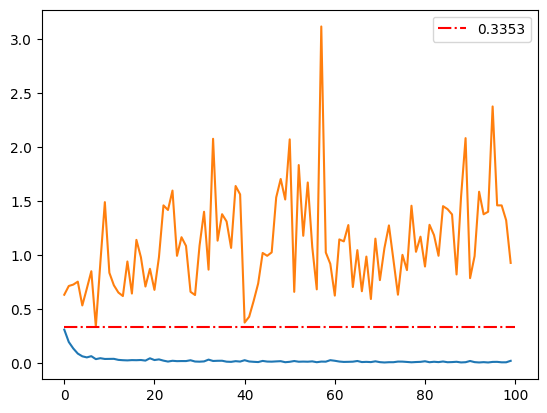

In [46]:
plt.plot(lossi)
plt.plot(devlossi)
devlossi_min = round(min(devlossi), ndigits=4)
plt.hlines([devlossi_min], xmin=0, xmax=len(devlossi), colors='red',linestyles='dashdot', label=devlossi_min)
plt.legend()

In [47]:
best_model.eval()
pred_logits = best_model(X_dev.cpu())

preds = pred_logits.cpu()
preds = (preds > 0.5).float()

In [48]:
print(classification_report(y_dev.cpu().numpy(), preds))

              precision    recall  f1-score   support

           0       0.94      0.86      0.90       651
           1       0.87      0.95      0.91       651

    accuracy                           0.90      1302
   macro avg       0.91      0.90      0.90      1302
weighted avg       0.91      0.90      0.90      1302



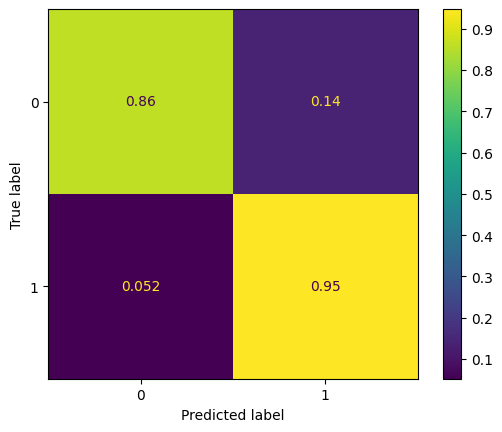

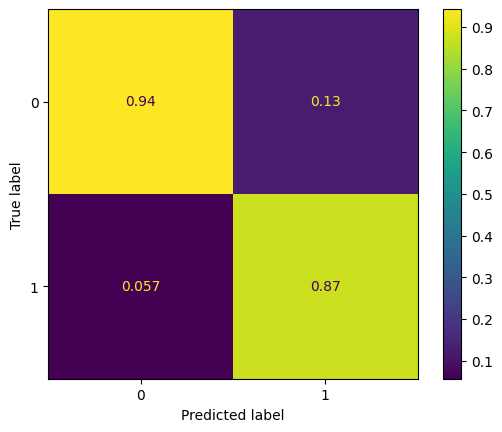

In [49]:
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='true')
ConfusionMatrixDisplay.from_predictions(y_dev.cpu().numpy(), preds, normalize='pred')